#### Anexo C

# Segmenación automática

#### Elaborado por: Ricardo Niño de Rivera Barrón

#### Ingeniería Biónica

#### Trabajo Terminal II

En esta libreta interactiva describimos el proceso para realizar la segementación automática.

In [1]:
#Importando bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import skimage
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage import feature
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
#Leyendo los archivos en los directorios de interés.
files=os.listdir("C:\\Users\\LapTop\\Desktop\\TERMOGRAFIA\\TT2\\BaseDeDatosFrontales_FINAL_256_bits\\train")

In [3]:
len(files)

3337

## Histogramas

Realizamos un muestreo exploratorio para observar como se comportan los histogramas.
Imprimos cada multiplo de 100.

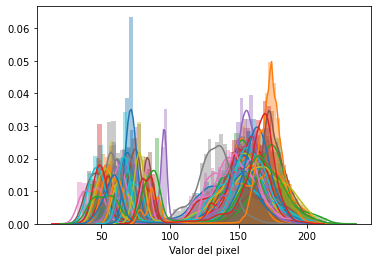

In [4]:
count=0

for i in files:
    if count%100==0:
        temp=np.load("C:\\Users\\LapTop\\Desktop\\TERMOGRAFIA\\TT2\\BaseDeDatosFrontales_FINAL_256_bits\\train\\"+i)
        sns.distplot(temp, axlabel="Valor del pixel")
    count+=1
    
    if count==3337:
        plt.savefig("Histogramas_Multiples_Sobrepuestos.png")

Como es posible observar, las distribuciones son bimodales, donde la primera moda describe la distribución relacionada al fondo de la imagen (background) y la segunda al objeto de interés (cuerpo del paciente).
A partir de aquí es posible implementar diferentes estrategias para eliminar los valores del background. Una de ellas es establecer un valor arbitrario utilizando como referencia la gráfica anterior, sin embargo  se realizará un proceso sensible a las diferentes distribuciones de las imágenes Que se describirá a continuación.

Primero visualizaremos un histograma cualesquiera.

In [5]:
temp=np.load("C:\\Users\\LapTop\\Desktop\\TERMOGRAFIA\\TT2\\BaseDeDatosFrontales_FINAL_256_bits\\train\\"+files[510])

In [6]:
files[510]

'T0045.1.1.D.2016-11-14.09.npy'

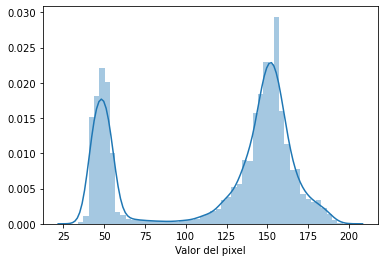

In [7]:
sns.distplot(temp, axlabel="Valor del pixel", norm_hist=True)
plt.savefig("Histograma_cualesquiera.png")

## Binarización por el método de Otsu

Utilizaremos un método de umbralización llamado OTSU.

El método fue diseñado con la intención de separar objectos o "secciones" de interés de una imagen (clases). Se basa en el supuesto de que cada objeto estará descrito por un segmento de la distribución de pixeles (histograma) haciendo posible su seperación al hallar umbrales que separen cada uno de los segmentos (clases).

En este caso el problema es encontrar un umbral que separe a los "montes" que definen al fondo y al objeto de interés, donde se observa que la distribución esta definida por dos "montes". De izquierda a derecha el primero describe al fondo y el segundo al objeto de interés. Estos "montes" pueden ser caracterizados por su media (o cualquier descriptor estadístico) en el segmento del 0 al umbral y del umbral al valor máximo del pixel en escala de grises. Por tanto, también es posible conocer la varianza en los segmentos, lo cual se conoce como varianza intraclase.

El objetico del método es encontrar un umbral que minimice las varianzas intraclase de tal forma que la varianza total (es decir, de todo el histograma) sea la mayor posible. Esta varianza total recibe el nombre de varianza interclase.

Para hallar dicho umbral se prueba sobre todos los valores posibles de pixeles (en este caso de 0 a 255), el valor que cumpla con las dos condiciones descritas anteriormente es el umbral elegido.

Para mayor detalle matemático de lo descrito enteriormente refierase al escrito de Trabajo Terminal I de este trabajo.

Por motivos de practicidad se implementará la biblioteca Scikit Image que implementa el proceso descrito para la obtención del umbral de interés.

Con nuestra imagen de prueba temp obtenemos el umbral mediante otsu.

In [8]:
umbral=threshold_otsu(temp)
print("Umbral de la imagen de prueba: "+str(umbral))

Umbral de la imagen de prueba: 100


In [9]:
#temp_hist=np.histogram(temp, bins=255, range=(0,255))

In [10]:
#Creando nuaveas imágenes para graficar el fondo y el objeto (paciente) en un histograma

objeto_mask=temp>=umbral
objeto=objeto_mask*temp
#Creando array de una sola dimensión
objeto=objeto.flatten()
objeto=np.delete(objeto, np.where(objeto == 0))

fondo_mask=temp<umbral
fondo=fondo_mask*temp
#Creando array de una sola dimensión
fondo=fondo.flatten()
fondo=np.delete(fondo, np.where(fondo == 0))

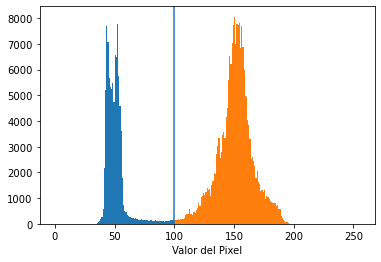

In [11]:
#Imprimiendo el termograma con el umbral obtenido
plt.hist(fondo, bins=255, range=(0,255))
plt.hist(objeto, bins=255, range=(0,255))
plt.xlabel("Valor del Pixel")
plt.axvline(x=umbral)
plt.savefig("Histograma_cualesquiera_umbral.png")

Ahora vamos a binarizar la imagen con el umbral obtenido (máscara).

In [12]:
temp_mask=objeto_mask
temp_umbral=temp*objeto_mask

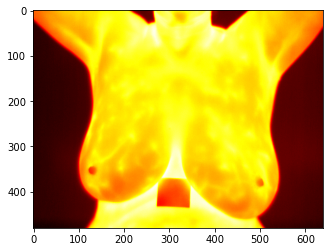

In [13]:
#Imprimiendo imagen original
plt.imshow(temp, cmap='hot')

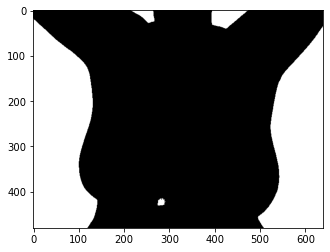

In [14]:
#Imprimiendo mascara por Otsu
plt.imshow(temp_mask, cmap='binary')

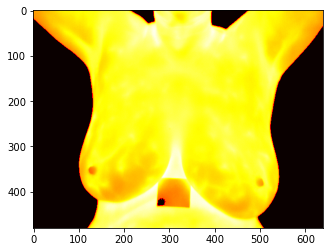

In [15]:
#Imprimiendo Imagen sin fondo
plt.imshow(temp_umbral, cmap='hot')

# Reducción del perfil

Primero recortamos el perfil de la mujer de tal forma que eliminemos los bordes orginales del cuerpo, así mismo se eliminará el 20% de la imagen de arriba hacia abajo (máscara).
Esto se realiza con el objetivo de eliminar el ruido generado por estos bordes y así mejorar la detección de los bordes de interés dentro del cuerpo que describan la mama.

In [16]:
temp_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [17]:
#Se realiza una copia y no una reasignación porque python no asigna un nuevo espacio de memoria en el segundo supuesto.
temp_mask2=temp_mask.copy()

#Creamos un for anidado para correr sobre las columnas, cuando encuentre el borde se enviarán ese y los siguientes 40 pixeles a False.
#Continuamos con la siguiente fila hasta que terminemos
for i in range(temp_mask.shape[0]):
    for j in range(temp_mask.shape[1]):
        if temp_mask[i,j]==True:
            temp_mask2[i,j:j+41]=0
            break

In [18]:
#Realizmos lo mismo pero para el lado izquierdo del paciente
for i in range(temp_mask.shape[0]):
    for j in range(temp_mask.shape[1]):
        if temp_mask[i,(temp_mask.shape[1]-1-j)]==True:
            temp_mask2[i,(temp_mask.shape[1]-1-j)-40:(temp_mask.shape[1]-1-j)+1]=0
            break

Imprimimos los resultados

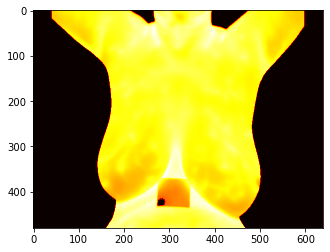

In [19]:
plt.imshow(temp_mask2*temp, cmap="hot")

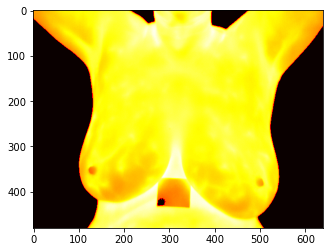

In [20]:
plt.imshow(temp_mask*temp, cmap="hot")

Ahora se elimina el ruido de los bordes de la sección superior.

In [21]:
#96 filas de pixeles (de arriba hacia abajo) es la cantidad que representa el 30% de la imagen 
upper_line=np.round(temp.shape[0]*0.30).astype(int)
upper_line

144

In [22]:
temp_mask2[0:upper_line,:]=0

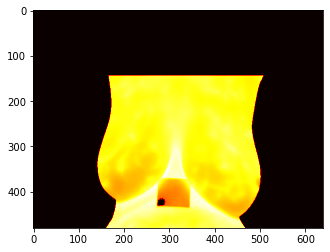

In [23]:
#Imprimiendo el resultado
plt.imshow(temp_mask2*temp, cmap="hot")

# Implementando operador SOBEL

El operador Sobel realiza dos convoluciones para enontrar bordes verticales u horizontales con una aproximación discreta del gradiente de cada punto de la imagen, dando como resultado una matriz con valores continuos. El resultado de este operador es una matriz donde cada punto es la norma del vector gradiente en el punto. Estos valores no son dicretos ni binarios sino valores continuos que se pueden interpretar como la intensidad con la que ese valor "representa" a un borde.

Como se sabe, mientras mayor sea el gradiente (en realidad norma del vector gradiente), más abrupto es el cambio de tonalidad de un punto a otro, por tanto se puede saber que los puntos con mayor "intensidad" resultantes de esta operación son "con mucha probabilidad" miembros de un borde de interés.

En la mayoría de las imágenes que se analizan en este trabajo los bordes inferiores de las mamas resaltan con mayor "intensidad", por tanto se presume que es posible obtener estos bordes utilizando el procesamiento propuesto.

In [24]:
edges3=skimage.filters.sobel(temp, mask=temp_mask2)

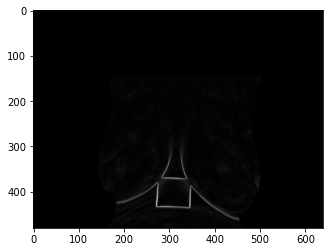

In [25]:
plt.imshow(edges3*temp_mask, cmap=plt.cm.gray)

Aquí aplicamos una umbralización por el método de Otsu nuevamente.

In [26]:
umbral3=skimage.filters.threshold_otsu(edges3*temp_mask)

In [27]:
np.max(temp)

196

In [28]:
umbral3

3.6204528141417683e-09

In [29]:
bina=edges3>=umbral3

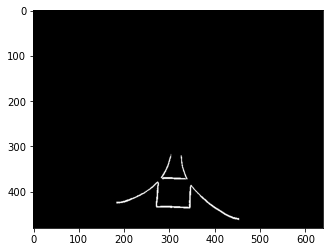

In [30]:
plt.imshow(bina, cmap=plt.cm.gray)

# Hallando los bordes inferiores de las mamas

Aquí nos encontramos con un problema propio de la adquisición debido a que el suministrador de los datos colocó en varias pacientes un cuadrado de un material no especificado. El problema para hallar los bordes de interés se ve comprometido por este  ruido propio de la adquisición. Sin embargo, en una inspección visual de una muestra aleatoria de las imágenes se observó que en la mayoría de los ejemplos de la muestra mencionada es posible discriminar los bordes generados por este cuadrado y obtener sólo los pixeles resaltados por el preprocesamiento anterior.

Por tanto se realiza un ciclo while para hallar los píxeles máximos en cada columna de la imagen. Ya que en la mayoría de los casos, los bordes inferiores de las mamas están arriba del mencionado cudrado.

Intuitivamente es posible sospechar que este método tenga problemas para identificar los bordes correctos, ya que se considerará el ruido creado por bordes superiores (como vasos sanguíneos), el cual podría interferir en la segmentación.

In [31]:
#Aquí almacenamos los índices que son True
index=np.where(bina!=False)

# Cómo resultado obtnemos un objeto tipo tuple donde conformado por dos arreglos, el primero son los índices de las filas
# El segundo son los índices de las columnas correspondientes a las índices del primer arreglo
index

(array([317, 318, 319, ..., 461, 461, 462], dtype=int32),
 array([304, 304, 304, ..., 453, 454, 454], dtype=int32))

In [32]:
index[1]

array([304, 304, 304, ..., 453, 454, 454], dtype=int32)

In [33]:
np.where(np.min(index[1])==index[1])

(array([1153, 1188, 1220, 1247], dtype=int32),)

In [34]:
index[0].shape[0]

1872

In [35]:
#Ahora vamos a hallar sólo los pixeles True superiores

# Creamos una copia de index
index_copy=index

#Creamos un arreglo 2D donde se almacenarán los nuevos valores de la imagen
final=np.zeros((temp.shape[0],temp.shape[1]))

while (index_copy[0].shape[0] and index_copy[1].shape[0]) != 0:
    
    #Primero hallamos los índices de las columnas que sean mínimos en index_copy, los almacenamos en index_temp
    index_temp=np.where(np.min(index_copy[1])==index_copy[1])
    
    #El método where de numpy retorna los índices de forma ordenada de menor a mayor
    #Nos interesa el primer valor para actualizar la matriz final
    
    final[index_copy[0][index_temp[0][0]], index_copy[1][index_temp[0][0]]]=1
    
    #Ahora eliminamos los valores en index_copy utilizando los índices que almacenamos en index_temp
    
    ind_temp0 = index_copy[0].copy()
    ind_temp1 = index_copy[1].copy()
    
    ind_temp_0 = np.delete(ind_temp0, index_temp)
    ind_temp_1 = np.delete(ind_temp1, index_temp)
    
    index_copy = (ind_temp_0, ind_temp_1)

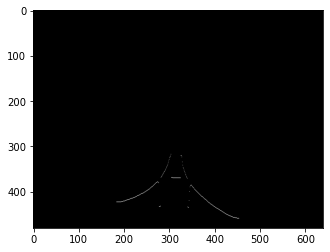

In [36]:
plt.imshow(final, cmap=plt.cm.gray)

# Ajustando dos parábolas

Ahora utilizamos una regresión cuadrática para aproximar dos parábolas, una para el borde izquierdo y otra para el borde derecho.

Vamos a realizar algunas restricciones para obtener los puntos necesarios.

Si no se halla una cantidad mínima de puntos por lado (izquierdo, derecho) no se realizará la segmentación

Se utilizará como referencia para encontrar el punto medio del cuerpo del paciente la imagen obtenida por binarización utilizando el método de Otsu previamente descrito en esta libreta. 

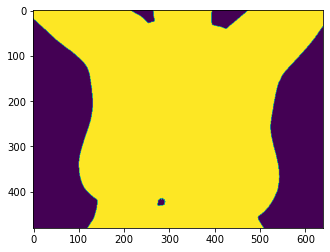

In [37]:
plt.imshow(temp_mask)

In [38]:
#Ubicando la posición del primero y el último True de la última fila de temp_mask
cintura=np.where(temp_mask[temp_mask.shape[0]-1,:]==True)

In [39]:
inicio=cintura[0][0]
fin=cintura[0][cintura[0].shape[0]-1]

In [40]:
intervalo_mitad=np.round((fin-inicio)/2)
intervalo_mitad

194.0

In [41]:
#indice mitad
index_mitad=int(inicio+intervalo_mitad)

Para el ejemplo que estamos analizando tenemos 231 puntos, algunos de ellos "ruido". Sin embargo, visualmente podemos observar que este ruido no supera el 25% de los puntos que obtenemos. Así que se propone 60 puntos como el mínimo de puntos de nuestro detector para hallar un borde.

In [42]:
np.sum(final)

271.0

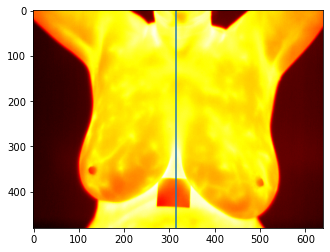

In [43]:
#Vamos a graficar nuestro valor de mitad encontrado con respecto a la imagen original
plt.imshow(temp, cmap='hot')
plt.axvline(x=index_mitad)

In [44]:
np.sum(final==1)

271

Creamos dos mascaras de los bordes de interés.

In [45]:
#Incializamos las máscaras en cero
mask_right=np.zeros((temp.shape[0],temp.shape[1]))
mask_left=np.zeros((temp.shape[0],temp.shape[1]))

In [46]:
#Asignamos los valores correspondientes
mask_right[:,:index_mitad]=final[:,:index_mitad]
mask_left[:,index_mitad:]=final[:,index_mitad:]

In [47]:
index_mitad

314

En la función final se agregará una condición para saber si mask_right y/o mask_left contienen los puntos mínimos necesarios y actuar en consecuencia, mientras tanto se ilustrará el procedimiento sin esta condición.

In [48]:
#Borde derecho
borde_derecho=np.where(mask_right==1)

In [49]:
#borde_izquierdo
borde_izquierdo=np.where(mask_left==1)

In [50]:
index_mitad

314

Ahora necesitamos cambiar las coordenadas a la convención del plano cartesiano.

In [51]:
#Arreglando coordenadas para el plano cartesiano
borde_derecho_plt=(borde_derecho[1], (final.shape[0]-1)-borde_derecho[0])

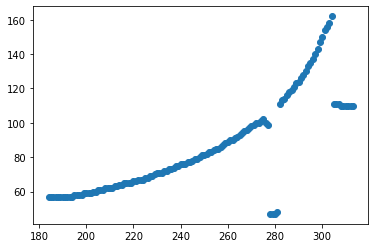

In [52]:
plt.scatter(borde_derecho_plt[0], borde_derecho_plt[1])

In [53]:
#Arreglando coordenadas para el plano cartesiano
borde_izquierdo_plt=(borde_izquierdo[1], (final.shape[0]-1)-borde_izquierdo[0])

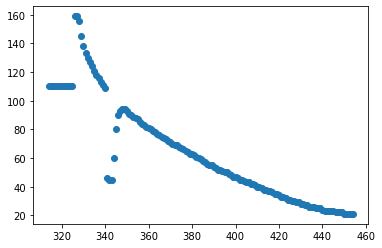

In [54]:
plt.scatter(borde_izquierdo_plt[0], borde_izquierdo_plt[1])

In [55]:
#Creamoas el modelo para ajustar los puntos del borde derecho
model_right = make_pipeline(PolynomialFeatures(2), Ridge())

In [56]:
#Agregando una dimensión
X_right=np.expand_dims(borde_derecho_plt[0], axis=1)
Y_right=np.expand_dims(borde_derecho_plt[1], axis=1)

In [57]:
#Ajustando el model utilizando una regresión cuadrática con ayuda de la biblioteca scikit learn
model_right.fit(X_right, Y_right)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge())])

In [58]:
Y_pred_right=model_right.predict(X_right)

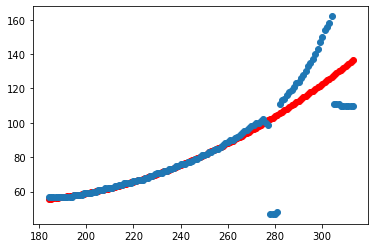

In [59]:
plt.scatter(X_right,Y_pred_right, color='red')
plt.scatter(X_right,Y_right)

El ruido causado por los puntos que no fueron eliminados en el preprocesamiento causados por los bordes del marcador cuadrado interfieren con el correcto ajuste de la curva. Para evitar esto eliminaremos estos puntos utilizando la curva previamente ajustada. 

In [60]:
#Eliminando puntos inferiores a la curva ajustada
fue=Y_right[np.where(Y_right>Y_pred_right)[0],:]

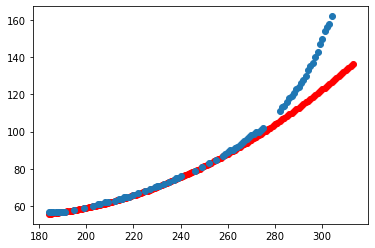

In [61]:
plt.scatter(X_right,Y_pred_right, color='red')
plt.scatter(X_right[np.where(Y_right>Y_pred_right)[0],:],fue)

La figura anterior muestra que el método utilizado consigue eliminar los puntos que no son de nuestro interés. Sin embargo, también elimina algunos puntos que no necesariamente son ruido, por tanto estableceremos una restricción establecida por un umbral arbitrario el cual nos ayudará a proporcionar un intervalo de tolerancia.

In [62]:
#Eliminando los puntos pero ahora estableciendo un umbral de 1 (distancia de los puntos a la curva ajustada)
fue1=Y_right[np.where(((Y_pred_right-Y_right)>1)==False)[0],:]

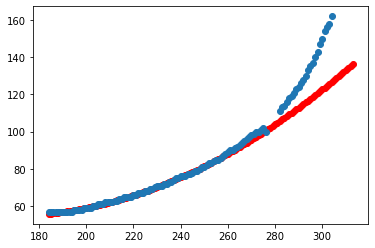

In [63]:
plt.scatter(X_right,Y_pred_right, color='red')
plt.scatter(X_right[np.where(((Y_pred_right-Y_right)>1)==False)[0],:],fue1)

Ahora realizamos una nueva regresión polinomial de segundo grado utilizando los puntos resultantes.

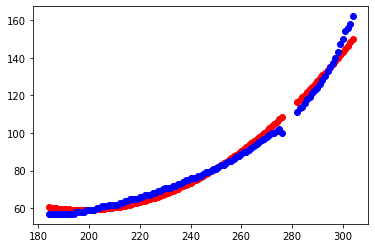

In [64]:
#Estableciendo el nuevo modelo
model_right2 = make_pipeline(PolynomialFeatures(2), Ridge())

#Ajustando el model utilizando una regresión cuadrática con ayuda de la biblioteca scikit learn
model_right2.fit(X_right[np.where(((Y_pred_right-Y_right)>1)==False)[0],:],fue1)

#Obteniendo predicciones para graficar el modelo cuadrático
Y_pred_right2=model_right2.predict(X_right[np.where(((Y_pred_right-Y_right)>1)==False)[0],:])

#Graficando modelo2 versus los puntos del borde
plt.scatter(X_right[np.where(((Y_pred_right-Y_right)>1)==False)[0],:],Y_pred_right2, color='red')
plt.scatter(X_right[np.where(((Y_pred_right-Y_right)>1)==False)[0],:],fue1, color='blue')

Ahora el borde izquierdo

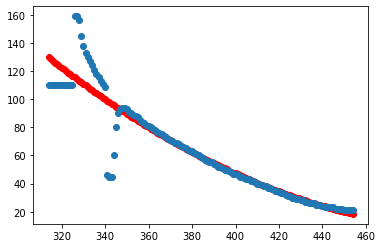

In [65]:
#Creamoas el modelo para ajustar los puntos del borde izquierdo
model_left = make_pipeline(PolynomialFeatures(2), Ridge())

#Agregando una dimensión
X_left=np.expand_dims(borde_izquierdo_plt[0], axis=1)
Y_left=np.expand_dims(borde_izquierdo_plt[1], axis=1)

#Ajustando el model utilizando una regresión cuadrática con ayuda de la biblioteca scikit learn
model_left.fit(X_left, Y_left)

Y_pred_left=model_left.predict(X_left)

plt.scatter(X_left,Y_pred_left, color='red')
plt.scatter(X_left,Y_left)


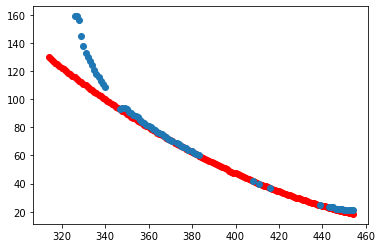

In [66]:
#Eliminando puntos inferiores a la curva ajustada
izq=Y_left[np.where(Y_left>Y_pred_left)[0],:]

plt.scatter(X_left,Y_pred_left, color='red')
plt.scatter(X_left[np.where(Y_left>Y_pred_left)[0],:],izq)

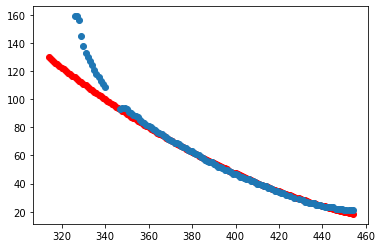

In [67]:
#Eliminando los puntos pero ahora estableciendo un umbral de 1
izq1=Y_left[np.where(((Y_pred_left-Y_left)>1)==False)[0],:]

plt.scatter(X_left,Y_pred_left, color='red')
plt.scatter(X_left[np.where(((Y_pred_left-Y_left)>1)==False)[0],:],izq1)

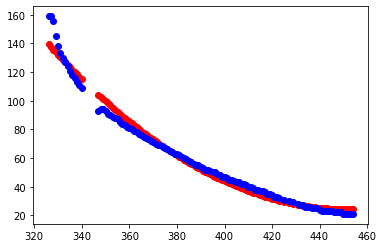

In [68]:
#Estableciendo el nuevo modelo
model_left2 = make_pipeline(PolynomialFeatures(2), Ridge())

#Ajustando el model utilizando una regresión cuadrática con ayuda de la biblioteca scikit learn
model_left2.fit(X_left[np.where(((Y_pred_left-Y_left)>1)==False)[0],:],izq1)

#Obteniendo predicciones para graficar el modelo cuadrático
Y_pred_left2=model_left2.predict(X_left[np.where(((Y_pred_left-Y_left)>1)==False)[0],:])

#Graficando modelo2 versus los puntos del borde
plt.scatter(X_left[np.where(((Y_pred_left-Y_left)>1)==False)[0],:],Y_pred_left2, color='red')
plt.scatter(X_left[np.where(((Y_pred_left-Y_left)>1)==False)[0],:],izq1, color='blue')

# Creando la máscara final

Con los dos modelos de los bordes más la mascara de binariación por Otsu nos es posible realizar las máscaras correspondientes para la segmentación de las regiones de interés como se describe a continuación.

Primero utilizaremos nuestros modelos finales (model_right2 y model_left2) para graficar nuestras parábolas.

In [69]:
#Generando el vector X_
X_=np.linspace(0,temp.shape[1]-1,temp.shape[1])

In [70]:
#Agregando una dimensión para evaluar el vector en los modelos
X_=np.expand_dims(X_, axis=1)

In [71]:
#Evaluando los modelos con el vector creado
parabol_right=model_right2.predict(X_)
parabol_left=model_left2.predict(X_)

In [72]:
#Eliminando una dimensión
X_=np.squeeze(X_, axis=1)
parabol_right=np.squeeze(parabol_right, axis=1)
parabol_left=np.squeeze(parabol_left, axis=1)

In [73]:
#Encontrando el punto donde se intersecan para su posterior utilización (Aproximación)
diferencia=np.abs(parabol_right-parabol_left)
intercc=np.where(np.min(diferencia)==diferencia)[0][0]
#Como están ordenados de 0 a el tamaño de la imagen en "x" entonces es posible utilizar este valor
print(intercc)


313


In [74]:
#Transformando los puntos a coordenadas de una imagen
index_parabol_right=(np.round((final.shape[0]-1)-parabol_right).astype(int), X_.astype(int))
index_parabol_left=(np.round((final.shape[0]-1)-parabol_left).astype(int), X_.astype(int))

In [75]:
#Eliminado los puntos que escapan a la resolución de la imagen

#Parábola derecha
index_parabol_right_rows_temp=np.delete(index_parabol_right[0], np.where(index_parabol_right[0] < 0))
X_index_right_temp=np.delete(index_parabol_right[1], np.where(index_parabol_right[0] < 0))

#Parábola izquierda
index_parabol_left_rows_temp=np.delete(index_parabol_left[0], np.where(index_parabol_left[0] < 0))
X_index_left_temp=np.delete(index_parabol_left[1], np.where(index_parabol_left[0] < 0))

In [76]:
#Actualizando las coordenadas de los bordes
index_parabol_right=(index_parabol_right_rows_temp, X_index_right_temp)
index_parabol_left=(index_parabol_left_rows_temp, X_index_left_temp)

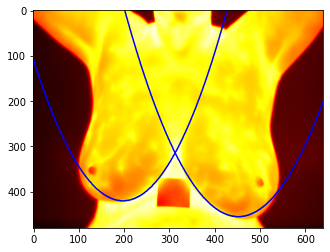

In [77]:
#Graficando parábolas con respecto a la imagen original
plt.imshow(temp, cmap='hot')
plt.plot(index_parabol_right[1], index_parabol_right[0], color='blue')
plt.plot(index_parabol_left[1], index_parabol_left[0], color='blue')

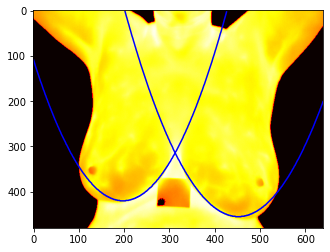

In [78]:
#Graficando parábolas con respecto a la imagen binarizada por Otsu
plt.imshow(temp_mask*temp, cmap='hot')
plt.plot(index_parabol_right[1], index_parabol_right[0], color='blue')
plt.plot(index_parabol_left[1], index_parabol_left[0], color='blue')

Como es posible observar en las imágenes anteriores, las parábolas son perfectibles. Por tanto se podrían utilizar nuevas técnicas como ajustar a nuevos puntos con base en el primer modelo, realizar un "desgaste" menor del perfil del cuerpo del paciente para obtener mayores puntos o utilizar otro método para dicho desgaste o relizar un ajuste a un modelo de grado 3 en lugar de grado 2. Así mismo es posible utilizar un modelo que aprenda las coordenadas de la región de interés utilizando imágenes previamente segmentadas. Sin embargo, estas técnicas no se aplicarán en este trabajo y se proponen como mejoras para trabajos futuros.

El resultado del ajuste a un polinomio de tercer grado se presenta a continuación.
![Ajuste a polinomio de tercer grado](segmentacion_grado3.png)

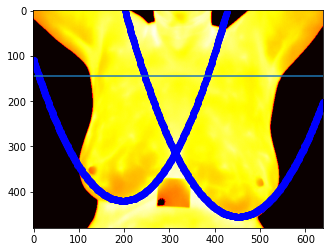

In [79]:
plt.imshow(temp_mask*temp, cmap='hot')
plt.scatter(index_parabol_right[1], index_parabol_right[0], color='blue')
plt.scatter(index_parabol_left[1], index_parabol_left[0], color='blue')
plt.axhline(y=upper_line)

Ahora graficamos con la linea horizontal donde las parábolas se intersecan.

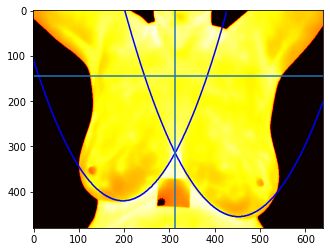

In [80]:
plt.imshow(temp_mask*temp, cmap='hot')
plt.plot(index_parabol_right[1], index_parabol_right[0], color='blue')
plt.plot(index_parabol_left[1], index_parabol_left[0], color='blue')
plt.axhline(y=upper_line)
plt.axvline(x=intercc)

Construyendo la máscara final.

In [81]:
#Máscara superior
upper_mask=np.zeros((temp.shape[0], temp.shape[1]))
upper_mask[upper_line:,:]=1

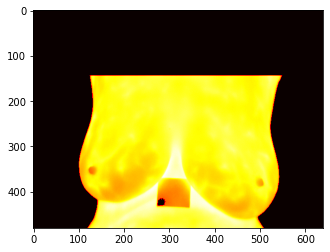

In [82]:
#Desplegando imagen sin fondo aplicando upper_mask
plt.imshow(temp*temp_mask*upper_mask,cmap="hot")

In [83]:
#Creando máscara con intercc para seno derecho
mask_right_side=np.zeros((temp.shape[0], temp.shape[1]))
mask_right_side[:, :intercc]=1

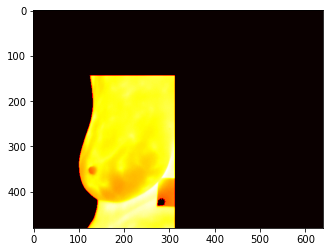

In [84]:
#Aplicando mask_right_side
plt.imshow(temp*temp_mask*upper_mask*mask_right_side,cmap="hot")

In [85]:
#Creando máscara con la parábola derecha

#Inicializando la máscara
parab_right_mask = np.zeros((temp.shape[0], temp.shape[1]))

#Estableciendo los valores superiores de la máscara a 1

for i in range(index_parabol_right[0].shape[0]):
    parab_right_mask[:index_parabol_right[0][i], i]=1


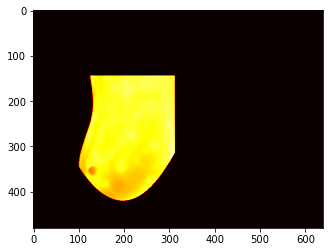

In [86]:
#Segementación final del seno derecho
plt.imshow(temp*temp_mask*upper_mask*mask_right_side*parab_right_mask,cmap="hot")

Ahora seno izquierdo.

In [87]:
#Creando máscara con intercc para seno derecho
mask_left_side=np.zeros((temp.shape[0], temp.shape[1]))
mask_left_side[:, intercc:]=1

In [88]:
#Creando máscara con la parábola izquierda

#Inicializando la máscara
parab_left_mask = np.zeros((temp.shape[0], temp.shape[1]))

#Estableciendo los valores superiores de la máscara a 1
count=0
for i in range(index_parabol_left[1][0], index_parabol_left[1][index_parabol_left[1].shape[0]-1]):
    parab_left_mask[:index_parabol_left[0][count], i]=1
    count+=1

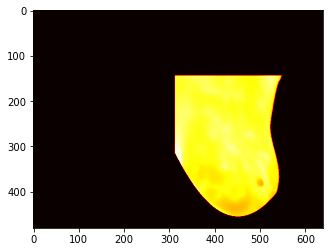

In [89]:
#Segementación final del seno izquierdo
plt.imshow(temp*temp_mask*upper_mask*mask_left_side*parab_left_mask,cmap="hot")

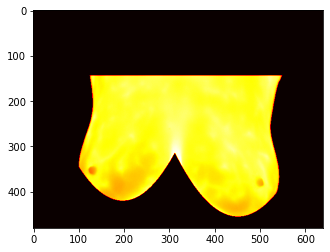

In [90]:
#Desplegando ambos segmentos

plt.imshow(temp*temp_mask*upper_mask*mask_right_side*parab_right_mask+temp*temp_mask*upper_mask*mask_left_side*parab_left_mask,cmap="hot")


Hemos finalizado la segementación, en la siguiente libreta se explicará el proceso para realizar el proceso descrito anteriormente en las imágenes restantes.